In [1]:
import h5py
import numpy as np
fh5 = h5py.File('d:/h5/fmap_cfl.h5','r')
img = fh5['map']
img = np.array(img)
print(img.shape)
lab = fh5['lab']
lab = np.array(lab)
print(lab.shape)

(11074, 33, 33)
(11074,)


In [2]:
img = img.reshape(len(img), 33, 33, 1)


In [3]:
lll = ['BLCA', 'BRCA', 'CESC', 'COAD', 'ESCA', 'GBM', 'HNSC', 'KIRP','KICH','KIRC', 'LAML', 'LGG', 'LIHC', 'LUAD', 'LUSC',
      'OV', 'PAAD','PRAD','PCPG','READ', 'SARC', 'SKCM', 'STAD', 'TGCT', 'THCA', 'THYM', 'UCEC']

In [4]:
lab

array([ 0.,  0.,  0., ..., 26., 26., 26.])

In [5]:
from tensorflow.keras.utils import to_categorical
train_labels = to_categorical(lab)
train_labels.shape

C:\Users\38152\.conda\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\38152\.conda\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\38152\.conda\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\38152\.conda\envs\tensorflow\lib\site-packages\tensorflow\

(11074, 27)

In [6]:
train_labels.shape

(11074, 27)

In [7]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(img,train_labels,test_size=0.2,random_state=3)

In [8]:
from keras import models
from keras import layers
from keras.models import Sequential,Input
from keras import optimizers
import keras
from keras.layers import Conv2D,MaxPooling2D,Dropout,BatchNormalization,Flatten,Dense,Lambda,Multiply,AveragePooling2D,Activation
from keras.models import Model

Using TensorFlow backend.


In [9]:
callbacks_list = [
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.5,patience=10),
    keras.callbacks.ModelCheckpoint(filepath='e:/data/rmap.h5',monitor='val_loss',save_best_only=True)   ##保存最佳模型
    ]

In [10]:
def Conv2d_BN(x, nb_filter,kernel_size, padding='valid',strides=(1,1),data_format='channels_last',dilation_rate=(1,1),
              activation='relu',name=None):
    if name is not None:
        bn_name = name + '_bn'
        conv_name = name + '_conv'
    else:
        bn_name = None
        conv_name = None
# inception 模块和 xception模块 bn层位置不一样

    #x = BatchNormalization(name=bn_name)(x)
    x = Conv2D(nb_filter,kernel_size,padding=padding,strides=strides,data_format='channels_last',activation='relu',
               dilation_rate=dilation_rate,name=conv_name)(x)
    x = BatchNormalization(name=bn_name)(x)
    
    return x

In [11]:
def InceptionB(x,nb_filter):
    branch_1x1_t = Conv2d_BN(x,nb_filter,(1,1), padding='same',strides=(1,1),data_format='channels_last',activation='relu',name=None)
    branch_1x1_t = Conv2d_BN(branch_1x1_t,nb_filter,(1,1), padding='same',strides=(1,1),data_format='channels_last',activation='relu',name=None)
    branch_1x1_s = Conv2d_BN(x,nb_filter,(1,1), padding='same',strides=(1,1),data_format='channels_last',activation='relu',name=None)
    branch_1x1_s = Activation('sigmoid')(branch_1x1_s)
    branch_1x1_c = keras.layers.Multiply()([branch_1x1_t,branch_1x1_s])
    
    branch_3x3_t = Conv2d_BN(x,nb_filter,(3,3), padding='same',strides=(1,1),data_format='channels_last',activation='relu',name=None)
    #branch_3x3_t = Conv2d_BN(branch_3x3_t,nb_filter,(3,3), padding='same',strides=(1,1),data_format='channels_last',activation='relu',name=None)
    branch_3x3_s = Conv2d_BN(x,nb_filter,(3,3), padding='same',strides=(1,1),data_format='channels_last',activation='relu',name=None)
    branch_3x3_s = Activation('sigmoid')(branch_3x3_s)
    branch_3x3_c = keras.layers.Multiply()([branch_3x3_t,branch_3x3_s])
       
    branch_5x5_t = Conv2d_BN(x,nb_filter,(5,5), padding='same',strides=(1,1),data_format='channels_last',activation='relu',name=None)
    #branch_5x5_t = Conv2d_BN(branch_5x5_t,nb_filter,(5,5), padding='same',strides=(1,1),data_format='channels_last',activation='relu',name=None)
    branch_5x5_s = Conv2d_BN(x,nb_filter,(5,5), padding='same',strides=(1,1),data_format='channels_last',activation='relu',name=None)
    branch_5x5_s = Activation('sigmoid')(branch_5x5_s)
    branch_5x5_c = keras.layers.Multiply()([branch_5x5_t,branch_5x5_s])
    

    x = keras.layers.Concatenate(axis=3)([branch_1x1_c,branch_3x3_c,branch_5x5_c]) #

    return x

In [12]:
def InceptionC(x,nb_filter):
    branch_1x1_t = Conv2d_BN(x,nb_filter,(1,1), padding='same',strides=(1,1),data_format='channels_last',activation='relu',name=None)
    branch_1x1_t = Conv2d_BN(branch_1x1_t,nb_filter,(1,1), padding='same',strides=(1,1),data_format='channels_last',activation='relu',name=None)
    branch_1x1_s = Conv2d_BN(x,nb_filter,(1,1), padding='same',strides=(1,1),data_format='channels_last',activation='relu',name=None)
    branch_1x1_s = Activation('sigmoid')(branch_1x1_s)
    branch_1x1_c = keras.layers.Multiply()([branch_1x1_t,branch_1x1_s])
    
    branch_3x3_t = Conv2d_BN(x,nb_filter,(3,3), padding='same',strides=(1,1),data_format='channels_last',activation='relu',name=None)
    #branch_3x3_t = Conv2d_BN(branch_3x3_t,nb_filter,(3,3), padding='same',strides=(1,1),data_format='channels_last',activation='relu',name=None)
    branch_3x3_s = Conv2d_BN(x,nb_filter,(3,3), padding='same',strides=(1,1),data_format='channels_last',activation='relu',name=None)
    branch_3x3_s = Activation('sigmoid')(branch_3x3_s)
    branch_3x3_c = keras.layers.Multiply()([branch_3x3_t,branch_3x3_s])
    

    x = keras.layers.Concatenate(axis=3)([branch_1x1_c,branch_3x3_c]) #branch_1x1_c,

    return x

In [13]:
def TestNet(input_shape=None):
    inpt = Input(shape=input_shape)
    #padding = 'same'，填充为(步长-1）/2,还可以用ZeroPadding3D((3,3,3))
    x = Conv2d_BN(inpt,32,(1,1),strides=(1,1),padding='same')
    x = Conv2d_BN(x,32,(1,1),strides=(1,1),padding='same')
    x = InceptionB(x,64)
    x = MaxPooling2D(pool_size=(2,2),strides=(2,2),padding='same')(x)
    x = InceptionB(x,128)
    x = MaxPooling2D(pool_size=(2,2),strides=(2,2),padding='same')(x)
    x = InceptionC(x,256)
    x = MaxPooling2D(pool_size=(2,2),strides=(2,2),padding='same')(x)
    x = InceptionC(x,512)
    x = AveragePooling2D(pool_size=(2,2),strides=(2,2),padding='same')(x)
    #x = Dropout(0.3)(x)
    x = Flatten()(x)
    x = Dense(128,activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(27,activation='softmax')(x)
    model = Model(inpt,x,name='inception')
    
 
    return model

In [14]:
model = TestNet(input_shape=(33,33,1))
model.summary()



Model: "inception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 33, 33, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 33, 33, 32)   64          input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 33, 33, 32)   128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 33, 33, 32)   1056        batch_normalization_1[0][0]      
________________________________________________________________________________________

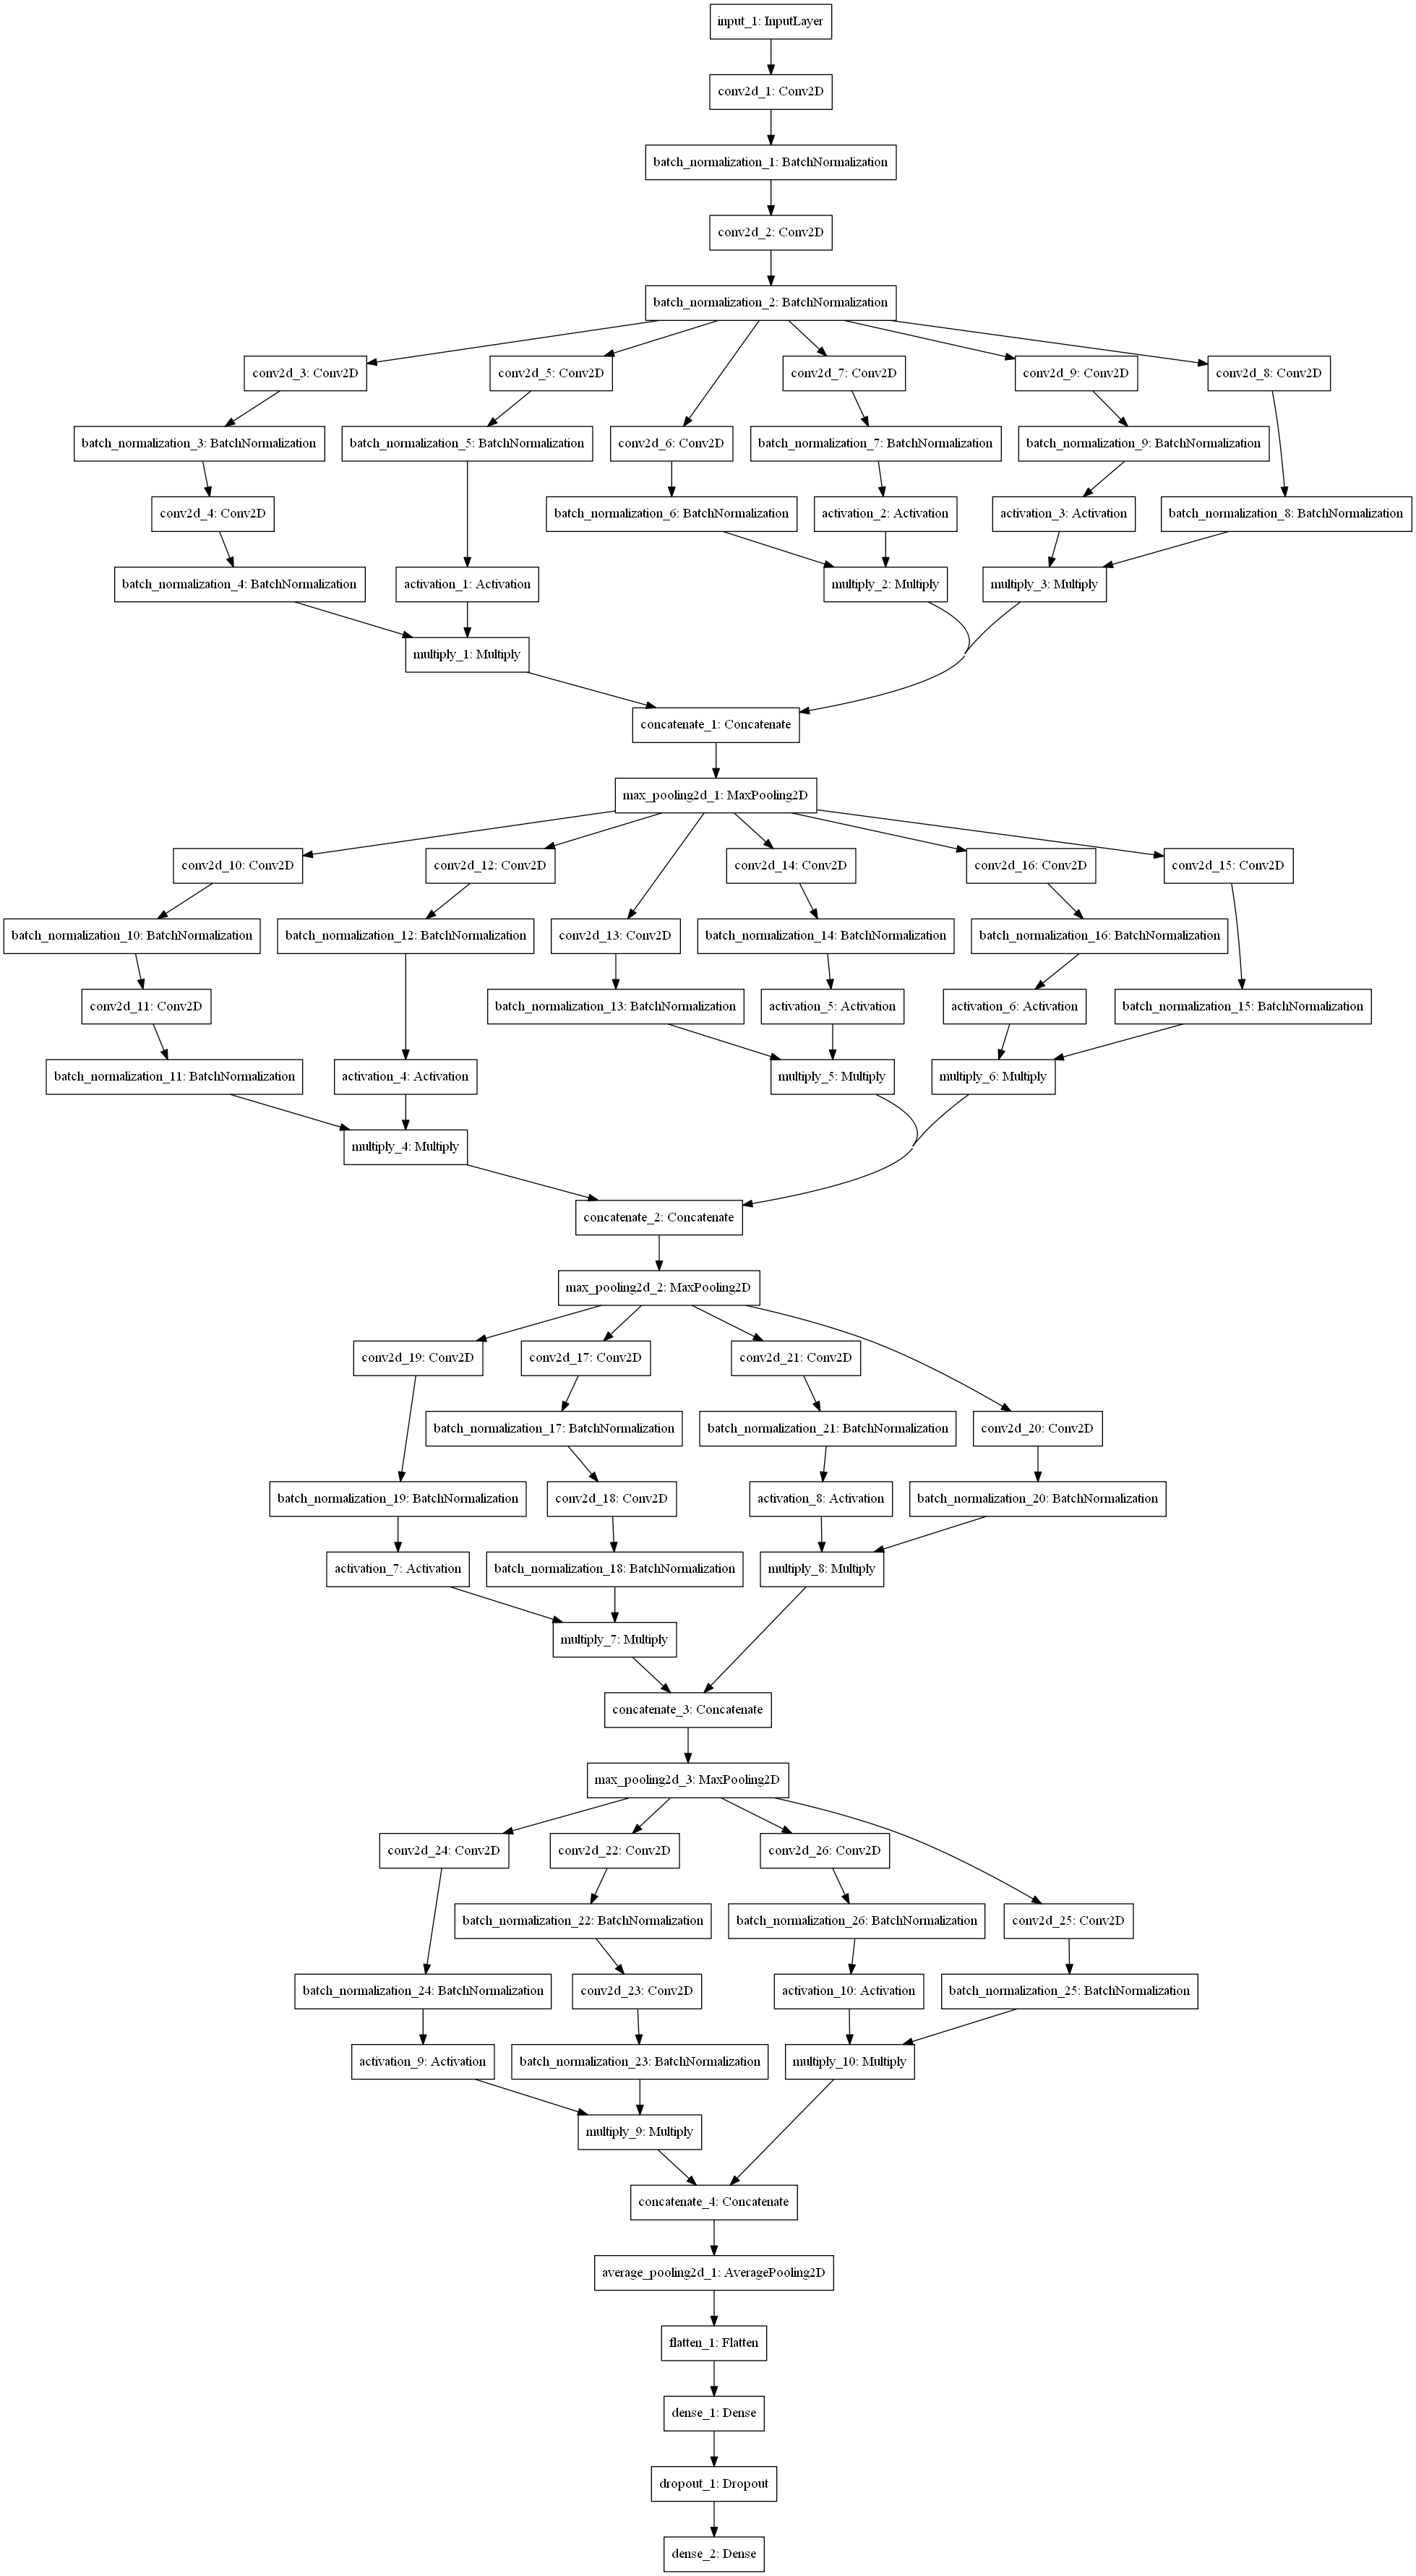

In [15]:
from tensorflow.keras.utils import plot_model     ##模型结构图
plot_model(model, 'd:\\h5\\model_3d.png')

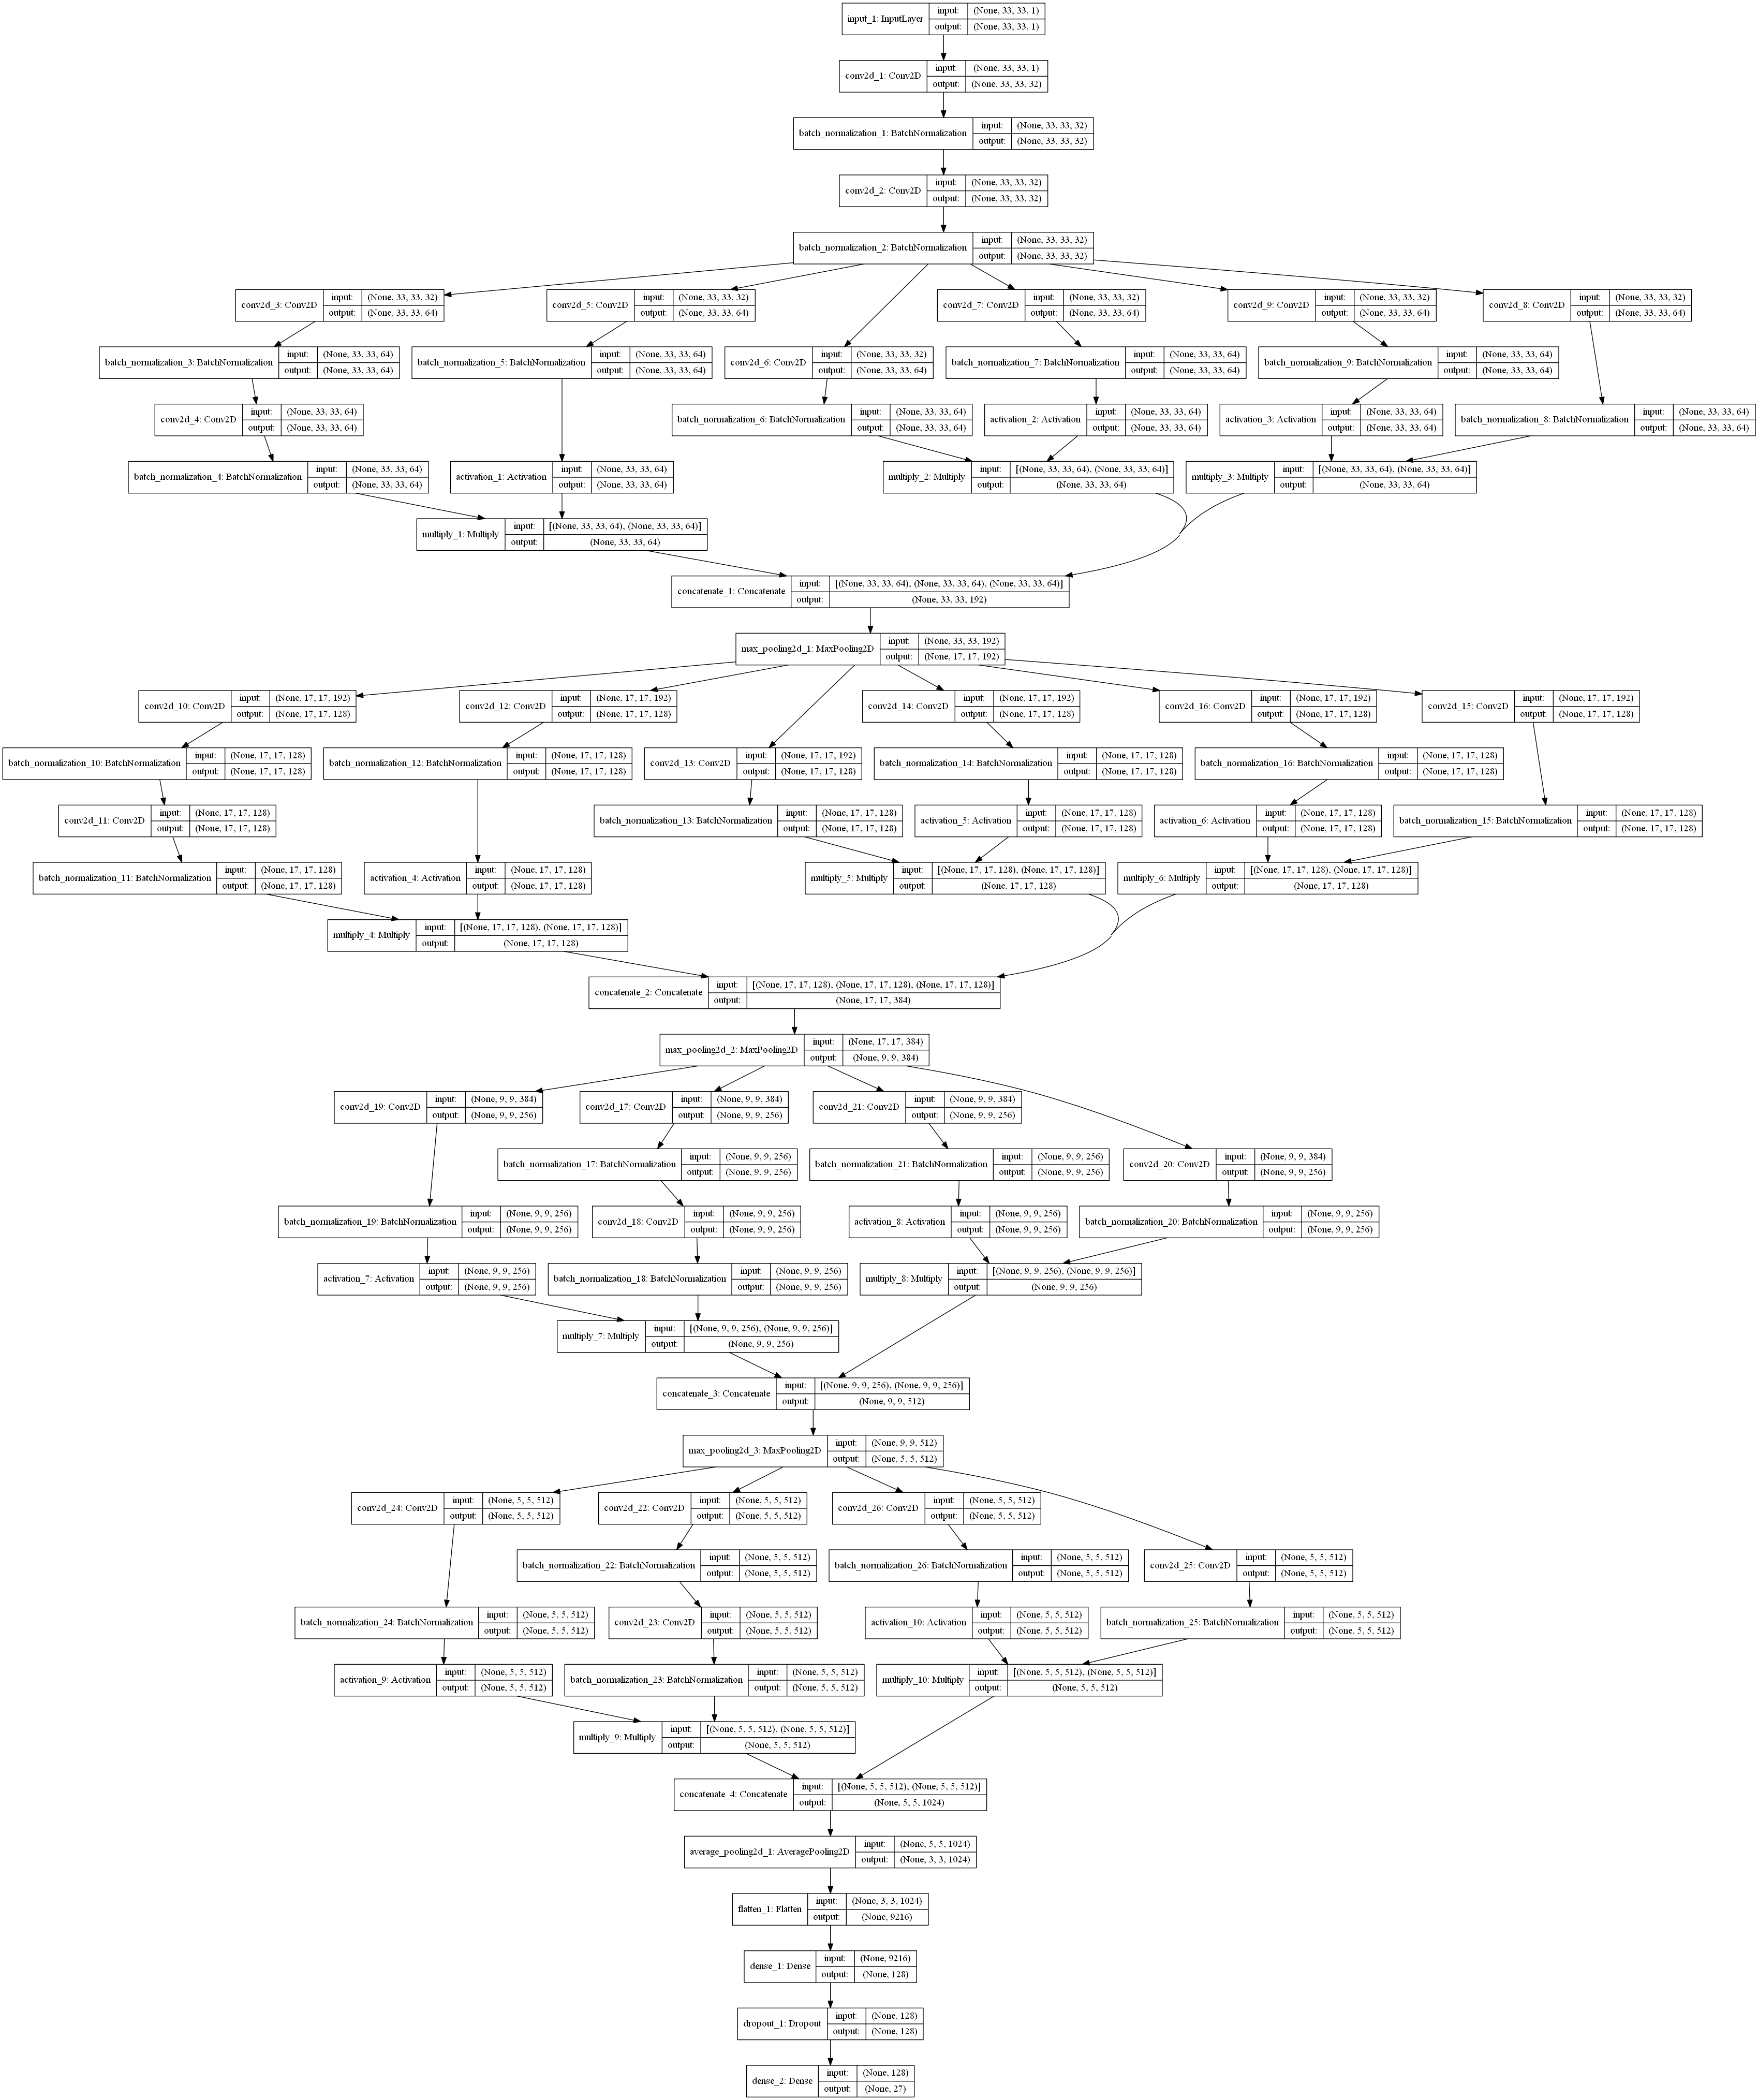

In [16]:
plot_model(model, 'd:\\h5\\model_3d.png',show_shapes=True)

In [17]:
from keras import backend as K
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [18]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=1e-5),#
              metrics=['acc']
              #metrics=['acc','Precision','Recall'] 
             )

In [19]:
his = model.fit(X_train,y_train,epochs=100,batch_size=256)#,callbacks = callbacks_list,validation_split=0.25


Epoch 1/100
8859/8859 [==============================] - 18s 2ms/step - loss: 2.8441 - acc: 0.2391
Epoch 2/100
8859/8859 [==============================] - 10s 1ms/step - loss: 2.1403 - acc: 0.5062
Epoch 3/100
8859/8859 [==============================] - 10s 1ms/step - loss: 1.6114 - acc: 0.6329
Epoch 4/100
8859/8859 [==============================] - 10s 1ms/step - loss: 1.2605 - acc: 0.7093
Epoch 5/100
8859/8859 [==============================] - 10s 1ms/step - loss: 1.0338 - acc: 0.7540
Epoch 6/100
8859/8859 [==============================] - 10s 1ms/step - loss: 0.8646 - acc: 0.7949
Epoch 7/100
8859/8859 [==============================] - 10s 1ms/step - loss: 0.7489 - acc: 0.8194
Epoch 8/100
8859/8859 [==============================] - 10s 1ms/step - loss: 0.6488 - acc: 0.8432
Epoch 9/100
8859/8859 [==============================] - 10s 1ms/step - loss: 0.5725 - acc: 0.8569
Epoch 10/100
8859/8859 [==============================] - 10s 1ms/step - loss: 0.5182 - acc: 0.8701
Epoch 11

In [20]:
test_loss,test_acc= model.evaluate(X_test,y_test)
print('test_acc:',test_acc)

2215/2215 [==============================] - 2s 778us/step
test_acc: 0.9097065329551697


In [21]:
predict = model.predict(X_test)
predict=np.argmax(predict,axis=1)

In [22]:
y_test2=np.argmax(y_test,axis=1)

In [23]:
predict.shape

(2215,)

In [24]:
predict

array([24, 15, 25, ..., 22, 14, 21], dtype=int64)

In [25]:
from sklearn.metrics import classification_report
print(classification_report(y_test2,predict,target_names=lll))

              precision    recall  f1-score   support

        BLCA       0.77      0.82      0.80        85
        BRCA       0.99      1.00      0.99       239
        CESC       0.84      0.75      0.79        51
        COAD       0.79      0.93      0.85       107
        ESCA       0.91      0.62      0.73        47
         GBM       1.00      0.94      0.97        34
        HNSC       0.92      0.96      0.94       157
        KIRP       0.81      0.87      0.84        15
        KICH       0.95      0.95      0.95       122
        KIRC       0.91      0.87      0.89        67
        LAML       1.00      1.00      1.00        31
         LGG       0.99      1.00      1.00       122
        LIHC       0.99      0.95      0.97        85
        LUAD       0.92      0.90      0.91       126
        LUSC       0.89      0.86      0.88        99
          OV       0.95      0.99      0.97        85
        PAAD       0.92      0.95      0.93        37
        PRAD       0.79    

In [26]:
#model.save_weights('d:/h5/fmap_cf_weights.h5')

In [27]:
from sklearn import neighbors
knn = neighbors.KNeighborsClassifier(n_neighbors=35)

In [28]:
x_train = X_train.reshape(8859, 33*33)

In [29]:
x_test = X_test.reshape(2215, 33*33)

In [30]:
knn.fit(x_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=35, p=2,
                     weights='uniform')

In [31]:
y_pred=knn.predict(x_test)
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred,target_names=lll))

              precision    recall  f1-score   support

        BLCA       0.84      0.42      0.56        85
        BRCA       0.99      0.87      0.92       239
        CESC       0.62      0.10      0.17        51
        COAD       0.71      0.88      0.78       107
        ESCA       1.00      0.06      0.12        47
         GBM       0.81      0.76      0.79        34
        HNSC       0.77      0.70      0.74       157
        KIRP       0.65      0.73      0.69        15
        KICH       0.94      0.83      0.88       122
        KIRC       0.93      0.75      0.83        67
        LAML       1.00      0.97      0.98        31
         LGG       0.97      0.93      0.95       122
        LIHC       0.99      0.94      0.96        85
        LUAD       0.88      0.56      0.69       126
        LUSC       0.67      0.40      0.50        99
          OV       0.98      0.98      0.98        85
        PAAD       0.97      0.76      0.85        37
        PRAD       0.81    

C:\Users\38152\.conda\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [32]:
y_train_labels = np.argmax(y_train,1)

In [33]:
y_test_labels = np.argmax(y_test,1)

In [34]:
from sklearn.svm import SVC
from sklearn.svm import NuSVC
svc = SVC( C=1.0, kernel='rbf', gamma='scale', decision_function_shape='ovr')
svc.fit(x_train,y_train_labels)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [35]:
y_pred=svc.predict(x_test)
from sklearn.metrics import classification_report
print(classification_report(y_test_labels,y_pred,target_names=None))

              precision    recall  f1-score   support

           0       0.76      0.87      0.81        85
           1       0.98      0.99      0.98       239
           2       0.80      0.69      0.74        51
           3       0.76      0.98      0.85       107
           4       0.96      0.53      0.68        47
           5       0.91      0.85      0.88        34
           6       0.86      0.90      0.88       157
           7       0.64      0.60      0.62        15
           8       0.92      0.93      0.93       122
           9       0.91      0.88      0.89        67
          10       1.00      1.00      1.00        31
          11       0.98      0.97      0.98       122
          12       0.99      0.96      0.98        85
          13       0.88      0.91      0.89       126
          14       0.81      0.78      0.79        99
          15       1.00      1.00      1.00        85
          16       0.94      0.92      0.93        37
          17       0.81    

C:\Users\38152\.conda\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [36]:
from sklearn.ensemble import RandomForestClassifier

In [37]:
RF=RandomForestClassifier(n_estimators=10, criterion='entropy')

In [38]:
RF.fit(x_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [39]:
y_pred=RF.predict(x_test)
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred,target_names=None))

              precision    recall  f1-score   support

           0       0.72      0.42      0.53        85
           1       1.00      0.90      0.94       239
           2       0.95      0.39      0.56        51
           3       0.77      0.77      0.77       107
           4       1.00      0.34      0.51        47
           5       1.00      0.91      0.95        34
           6       0.96      0.80      0.87       157
           7       0.86      0.40      0.55        15
           8       0.99      0.87      0.93       122
           9       0.96      0.79      0.87        67
          10       1.00      1.00      1.00        31
          11       1.00      0.98      0.99       122
          12       1.00      0.94      0.97        85
          13       0.95      0.59      0.73       126
          14       0.89      0.52      0.65        99
          15       1.00      0.88      0.94        85
          16       1.00      0.65      0.79        37
          17       0.79    

C:\Users\38152\.conda\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [40]:
from sklearn.ensemble import GradientBoostingClassifier

In [41]:
gbdt = GradientBoostingClassifier(n_estimators=20)

In [42]:
gbdt.fit(x_train,y_train_labels) 

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=20,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [43]:
y_pred=gbdt.predict(x_test)
from sklearn.metrics import classification_report
print(classification_report(y_test_labels,y_pred,target_names=None))

              precision    recall  f1-score   support

           0       0.76      0.76      0.76        85
           1       0.92      0.97      0.95       239
           2       0.83      0.76      0.80        51
           3       0.74      0.86      0.79       107
           4       0.74      0.60      0.66        47
           5       0.97      0.91      0.94        34
           6       0.86      0.95      0.90       157
           7       0.78      0.93      0.85        15
           8       0.95      0.92      0.93       122
           9       0.86      0.90      0.88        67
          10       1.00      1.00      1.00        31
          11       0.98      0.99      0.99       122
          12       1.00      0.95      0.98        85
          13       0.90      0.88      0.89       126
          14       0.80      0.81      0.80        99
          15       0.98      0.95      0.96        85
          16       0.89      0.89      0.89        37
          17       0.81    